# Plot Multiple Timepoints

This script creates plots that summarize the evolution of the density in differt ROIs across differt timepoints. The Region of Injection is keept constant.

## Packages

In [49]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Mandatory Input

In [50]:
# Dir of the project (if script is run on batch mode, i.e. for all brains of the project)
dir_project = "/run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/connectome_analysis/final_dataset"

# Csv file with all the brains data
csv_file = "/run/user/1000/gvfs/smb-share:server=upcourtinenas,share=cervical/CERVICAL_ID/Connectome_analysis/Final_dataset/Results/all_brains.csv"

# number of the ROI to display in a plot
n_roi_displayed = 10 

# List of region to injection to invesigate (one for each folder in the porject)
region_injections = ["DR", "GPi", "STN", "PARN", "IF", "GPe", "CU", "BST"]
# List of Timepoints to investigate
timepoints = ["Uninjured", "1 weeks", "8 weeks"]


## Useful Functions

In [51]:
def data_summary(data, varname, groupnames):
    """
    Function to calculate the mean and standard error for each group, preserving the original order.

    Parameters:
    - data: A pandas DataFrame containing the data.
    - varname: The name of the column containing the variable to be summarized (string).
    - groupnames: A list of column names to be used as grouping variables (list of strings).

    Returns:
    - data_sum: A pandas DataFrame with mean and standard error for each group, preserving the original order.
    """
    
    # Add an index column to preserve the original order
    data['_order'] = range(len(data))
    
    # Group the data by the specified group names
    grouped = data.groupby(groupnames)
    
    # Calculate the mean and standard error for the specified variable
    data_sum = grouped[varname].agg(
        mean='mean', 
        std='std', 
        count='count'
    ).reset_index()
    
    # Calculate standard error
    data_sum['sem'] = data_sum['std'] / np.sqrt(data_sum['count'])
    
    # Merge the summary with the original data to preserve the order
    data_sum = pd.merge(data[groupnames + ['_order']], data_sum, on=groupnames).sort_values('_order')

    # Check for duplicates in the summary DataFrame
    if data_sum.duplicated(subset=groupnames).any():
        print("Warning: Duplicates found in the summarized data!")
        # Drop duplicates, keeping the first occurrence
        data_sum = data_sum.drop_duplicates(subset=groupnames)
    
    # Sort the summary DataFrame based on the preserved order from the original data
    data_sum['_order'] = data.groupby(groupnames)['_order'].first().values
    data_sum = data_sum.sort_values('_order')
    
    # Drop the temporary _order column
    data_sum = data_sum.drop(columns=['_order'])
    
    # Rename the mean and sem columns
    data_sum = data_sum.rename(columns={'mean': varname + '_mean', 'sem': varname + '_sem', 'std': varname + '_std'})
    
    # Drop the 'std' and 'count' columns, as they are not needed
    #data_sum = data_sum.drop(columns=['std', 'count'])
    
    return data_sum

def search_injection_folder(base_dir, name_dir_to_search):
    """
    Searches for a subfolder with a specific name within the given base directory.

    Parameters:
    - base_dir: The path of the base directory to search within (string).
    - name_dir_to_search: The name of the subfolder to search for (string).

    Returns:
    - The full path of the subfolder if found, or None if not found.
    """
    # Ensure the base directory exists
    if not os.path.isdir(base_dir):
        raise ValueError(f"The base directory '{base_dir}' does not exist or is not a directory.")
    
    # Walk through the directory tree
    for root, dirs, files in os.walk(base_dir):
        if name_dir_to_search in dirs:
            # Return the full path to the subfolder
            return os.path.join(root, name_dir_to_search)
    
    # Return None if the subfolder was not found
    return None


## Read csv all Brains

In [52]:
df_all = pd.read_csv(csv_file)

## 3 Timepoints Barplot most dense, different x-axis

In [16]:
# Summarize data
df_summary = data_summary(df_all, varname="Cell Density", groupnames=["TimePoint", "Region Injection", "ROI"])
    # in this way I take the mean of:
        # the same ROI, coming from mice of the same timepoint and same Region Injection

# Loop over each region
for region in region_injections:

    print(f"Analyzing data for Region Injection: {region}")
    
    # Set up the plot grid
    n_plots = len(timepoints)
    fig, axes = plt.subplots(nrows=1, ncols=n_plots, figsize=(5 * n_plots, 6), sharey=True)
    
    if n_plots == 1:
        axes = [axes]  # Ensure axes is a list even for a single plot
    
    # Plot for each time point
    for i, timepoint in enumerate(timepoints):
        
        # Filter data for the current time point
        t = df_summary[(df_summary["TimePoint"] == timepoint) & (df_summary["Region Injection"] == region)]
        
        # Sort by mean density and select top ROIs
        t_sorted = t.sort_values(by="Cell Density_mean", ascending=False).head(n_roi_displayed)
        
        # Create the bar plot on the corresponding subplot
        axes[i].bar(t_sorted["ROI"], t_sorted["Cell Density_mean"], yerr=t_sorted["Cell Density_sem"], color="lightblue", capsize=5)
        axes[i].set_title(f"{timepoint}")
        axes[i].set_xticks(range(len(t_sorted["ROI"])))  # Set the positions of the ticks
        axes[i].set_xticklabels(t_sorted["ROI"], rotation=45, ha='right')  # Set the labels
        axes[i].set_ylim(0, 0.02)
    
    # Set a common y-label
    fig.text(0.04, 0.5, 'Cell Density Mean', va='center', rotation='vertical')
    
    # Adjust layout
    plt.tight_layout(rect=[0.05, 0, 1, 1])
    
    # Save the combined plot
    injection_folder = search_injection_folder(dir_project, region) # Search the dolfer of the injection
    result_folder = os.path.join(injection_folder, "Results") 
    os.makedirs(result_folder, exist_ok=True)
    fig.savefig(os.path.join(result_folder, f"timepoints_barplot_different_xaxis_{n_roi_displayed}.pdf"), bbox_inches="tight")

plt.close("all")


Analyzing data for Region Injection: DR
Analyzing data for Region Injection: STN
Analyzing data for Region Injection: PARN
Analyzing data for Region Injection: IF
Analyzing data for Region Injection: GPi
Analyzing data for Region Injection: GPe
Analyzing data for Region Injection: CU
Analyzing data for Region Injection: BST


## Barplot Multiple columns

In [17]:
# Summarize data
df_summary = data_summary(df_all, varname="Cell Density", groupnames=["TimePoint", "Region Injection", "ROI"])
    # in this way I take the mean of:
        # the same ROI, coming from mice of the same timepoint and same Region Injection

def multiple_bar_barplot(df_summary, baseline_timepoint = "Uninjured"):

    print(f"Analyzing baseline {baseline_timepoint}")
    # Define colors for the timepoints
    colors = plt.get_cmap('tab10').colors  # Use the 'tab10' colormap for distinct colors
    color_map = {timepoint: colors[i % len(colors)] for i, timepoint in enumerate(timepoints)}
        
    for region in region_injections:
        print(f"\tAnalyzing data for Region Injection: {region}")

        # Select only specific region of injection
        df_region = df_summary[df_summary["Region Injection"] == region]

        if df_region.shape[0] == 0:
            print(f"\t\tATTENTION --> No data for Injection Region {region}")
            continue

        # Filter data for the baseline case
        baseline_data = df_region[df_region["TimePoint"] == baseline_timepoint]

        # Find the most dense region for the "Uninjured" case
        most_dense_regions = baseline_data.sort_values(by="Cell Density_mean", ascending=False).head(n_roi_displayed)
        most_dense_region_list = most_dense_regions["ROI"].tolist()
        
        # Filter data for the specific regions and timepoints
        filtered_data = df_region[df_region["ROI"].isin(most_dense_region_list)]

        if filtered_data.shape[0] == 0:
            print(f"\t\tATTENTION --> No data for baseline {baseline_timepoint} in Injection Region {region}")
            continue

        # Pivot data for plotting
        pivot_data = filtered_data.pivot_table(index="ROI", columns="TimePoint", values="Cell Density_mean", aggfunc='mean')
        pivot_errors = filtered_data.pivot_table(index="ROI", columns="TimePoint", values="Cell Density_sem", aggfunc='mean')

        # Ensure columns are ordered by the given timepoints list and include only available timepoints
        available_timepoints = [tp for tp in timepoints if tp in pivot_data.columns]
        pivot_data = pivot_data[available_timepoints]
        pivot_errors = pivot_errors[available_timepoints]

        # Ensure order is decreseing based oin baseline timepoint
        pivot_data = pivot_data.sort_values(by=baseline_timepoint, ascending=False)
        pivot_errors = pivot_errors.sort_values(by=baseline_timepoint, ascending=False)

        # Create a single bar plot
        fig, ax = plt.subplots(figsize=(10, 6))
        pivot_data.plot(kind='bar', yerr=pivot_errors, ax=ax, capsize=5, color=[color_map[timepoint] for timepoint in timepoints])

        # Format the plot
        ax.set_title(f"Cell Density for Region Injection: {region} (Top Dense Regions)")
        ax.set_xlabel("ROI")
        ax.set_ylabel("Cell Density Mean")
        ax.set_xticklabels(pivot_data.index, rotation=45, ha='right')
        ax.set_ylim(0, 0.02)

        # Adjust layout
        plt.tight_layout()
        
        # Save the combined plot
        injection_folder = search_injection_folder(dir_project, region) # Search the dolfer of the injection
        result_folder = os.path.join(injection_folder, "Results") 
        os.makedirs(result_folder, exist_ok=True)
        fig.savefig(os.path.join(result_folder, f"timepoints_barplot_muultiple_bars_baseline_{baseline_timepoint}_{n_roi_displayed}.pdf"), bbox_inches="tight")

        print(f"\t\tSuccess!")

    plt.close("all")
    print("\n")


for t in timepoints:
    multiple_bar_barplot(df_summary, baseline_timepoint=t)




Analyzing baseline Uninjured
	Analyzing data for Region Injection: DR
		Success!
	Analyzing data for Region Injection: STN
		ATTENTION --> No data for Injection Region STN
	Analyzing data for Region Injection: PARN
		ATTENTION --> No data for Injection Region PARN
	Analyzing data for Region Injection: IF
		ATTENTION --> No data for Injection Region IF
	Analyzing data for Region Injection: GPi
		Success!
	Analyzing data for Region Injection: GPe
		Success!
	Analyzing data for Region Injection: CU
		ATTENTION --> No data for Injection Region CU
	Analyzing data for Region Injection: BST
		ATTENTION --> No data for Injection Region BST


Analyzing baseline 1 weeks
	Analyzing data for Region Injection: DR
		Success!
	Analyzing data for Region Injection: STN
		ATTENTION --> No data for Injection Region STN
	Analyzing data for Region Injection: PARN
		ATTENTION --> No data for Injection Region PARN
	Analyzing data for Region Injection: IF
		ATTENTION --> No data for Injection Region IF
	Analy

## Boxplot single ROI across timepoints

/tmp/ipykernel_41794/2724148067.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.27950788e-01 2.12086676e-01 1.14505890e-01 ... 3.98506489e-04
 2.10675405e-04 0.00000000e+00]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_norm.loc[df_norm["Brain ID"] == ID, "Normalised Synapses"] = df_norm.loc[df_norm["Brain ID"] == ID, "Synapses"] / tot_synapses
/tmp/ipykernel_41794/2724148067.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x="TimePoint", y="Normalised Synapses", data=df_roi_left,
/tmp/ipykernel_41794/2724148067.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the s

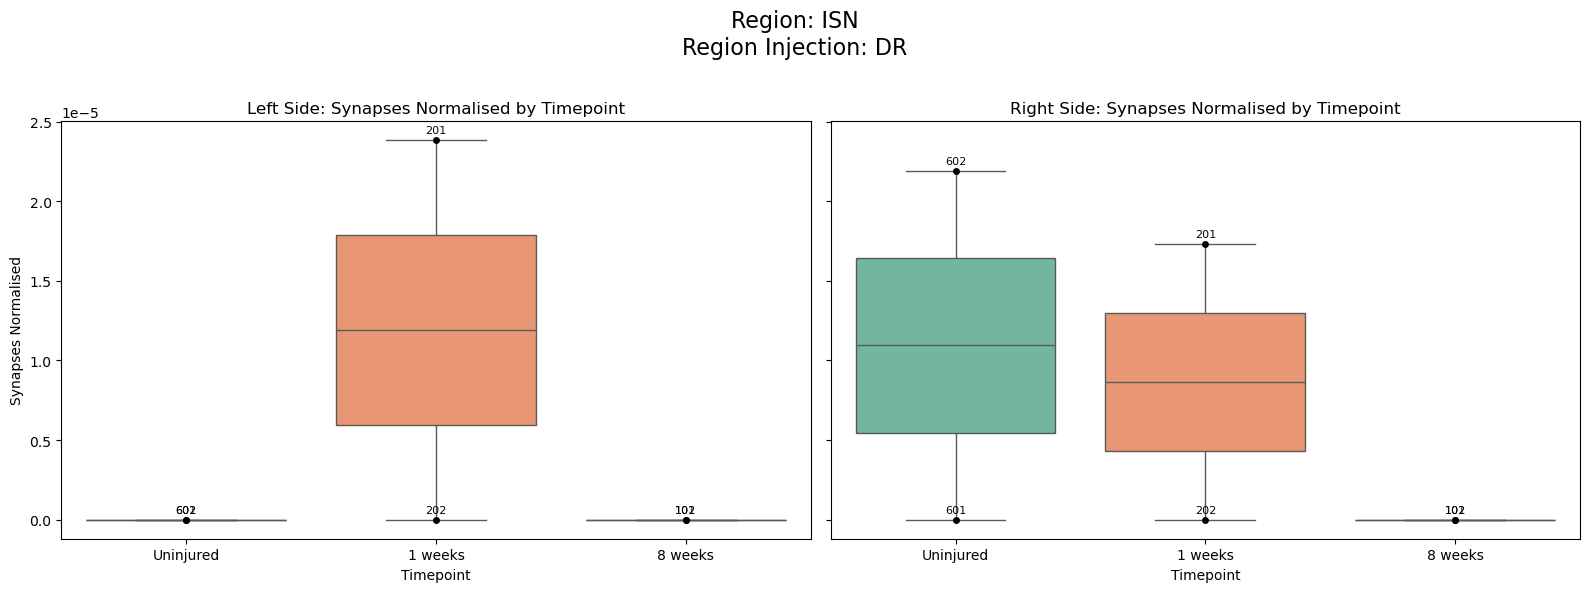

/tmp/ipykernel_41794/2724148067.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x="TimePoint", y="Normalised Synapses", data=df_roi_left,
/tmp/ipykernel_41794/2724148067.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], x="TimePoint", y="Normalised Synapses", data=df_roi_right,


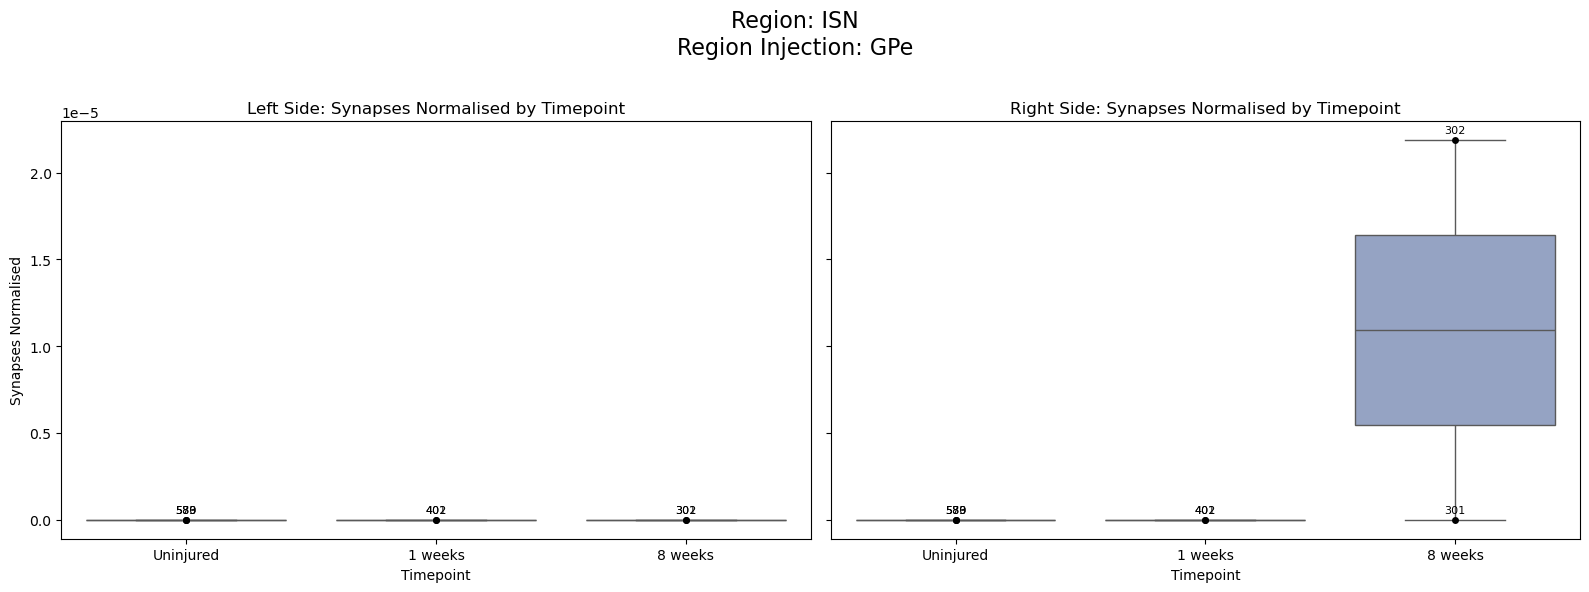

/tmp/ipykernel_41794/2724148067.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x="TimePoint", y="Normalised Synapses", data=df_roi_left,
/tmp/ipykernel_41794/2724148067.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], x="TimePoint", y="Normalised Synapses", data=df_roi_right,


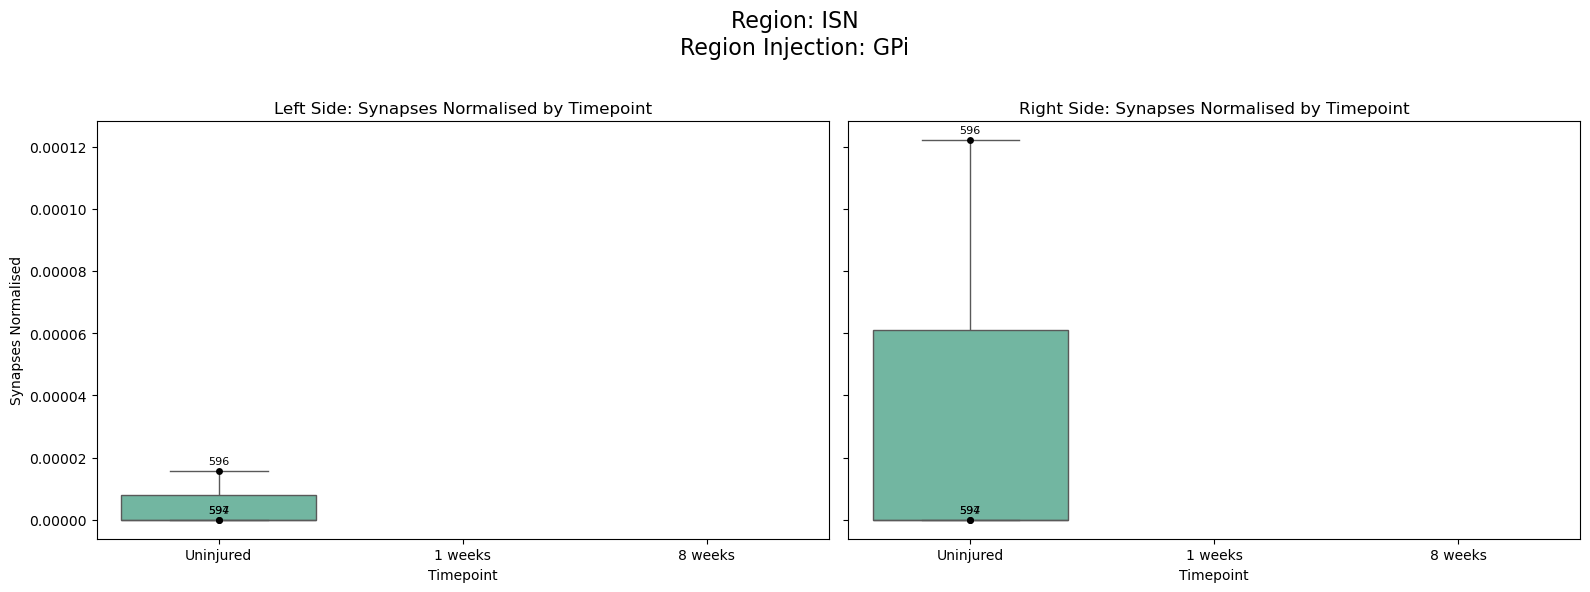

/tmp/ipykernel_41794/2724148067.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x="TimePoint", y="Normalised Synapses", data=df_roi_left,
/tmp/ipykernel_41794/2724148067.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], x="TimePoint", y="Normalised Synapses", data=df_roi_right,


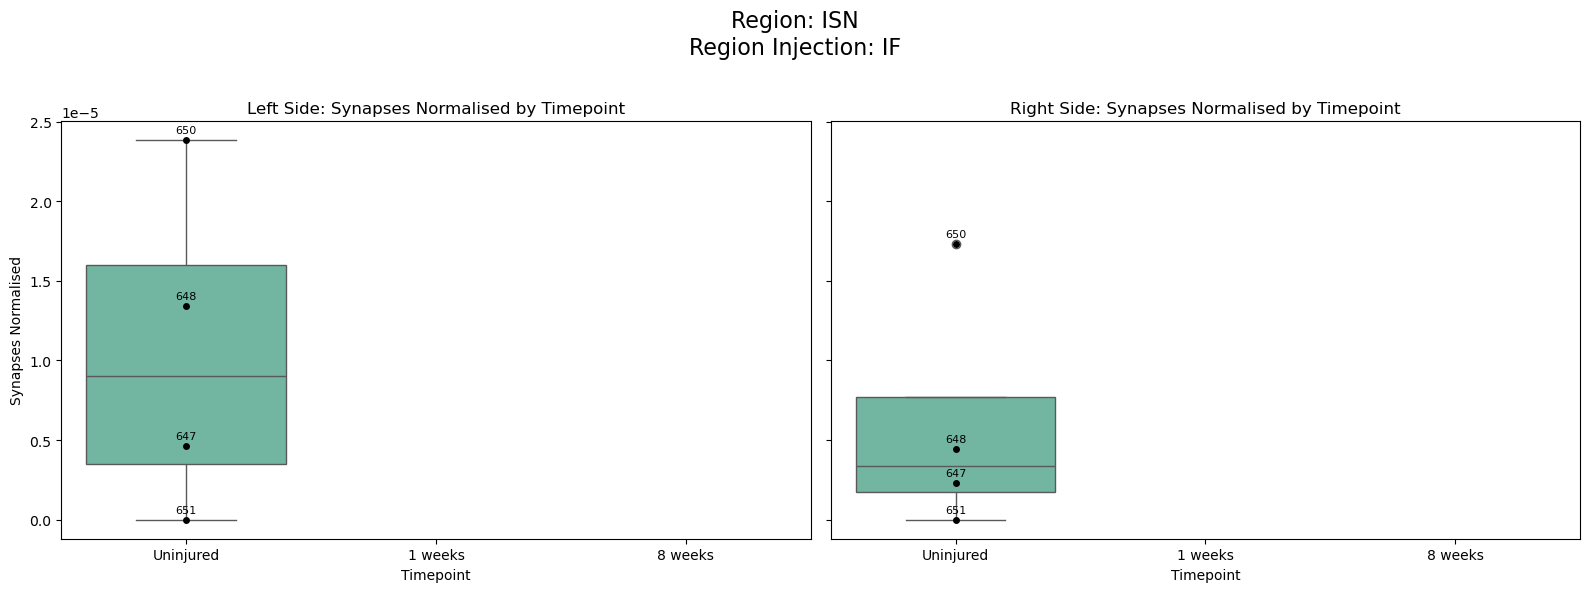

/tmp/ipykernel_41794/2724148067.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x="TimePoint", y="Normalised Synapses", data=df_roi_left,
/tmp/ipykernel_41794/2724148067.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], x="TimePoint", y="Normalised Synapses", data=df_roi_right,


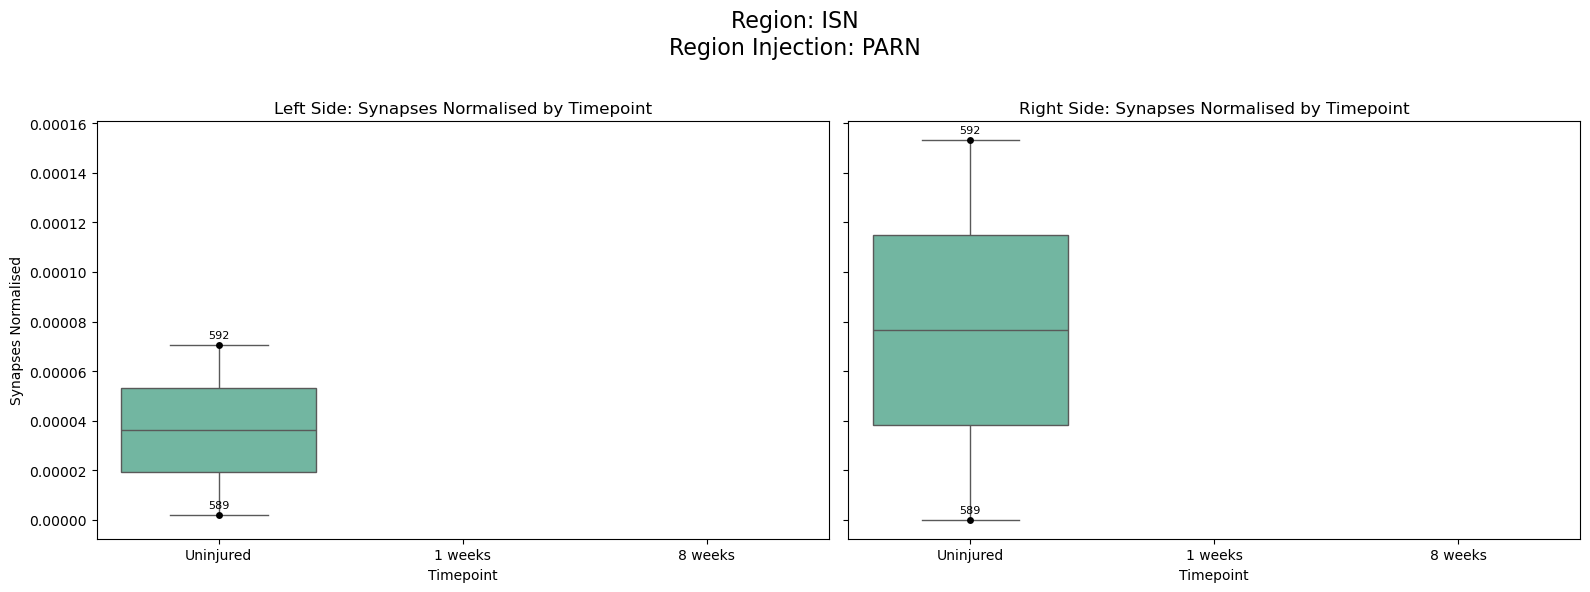

/tmp/ipykernel_41794/2724148067.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x="TimePoint", y="Normalised Synapses", data=df_roi_left,
/tmp/ipykernel_41794/2724148067.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], x="TimePoint", y="Normalised Synapses", data=df_roi_right,


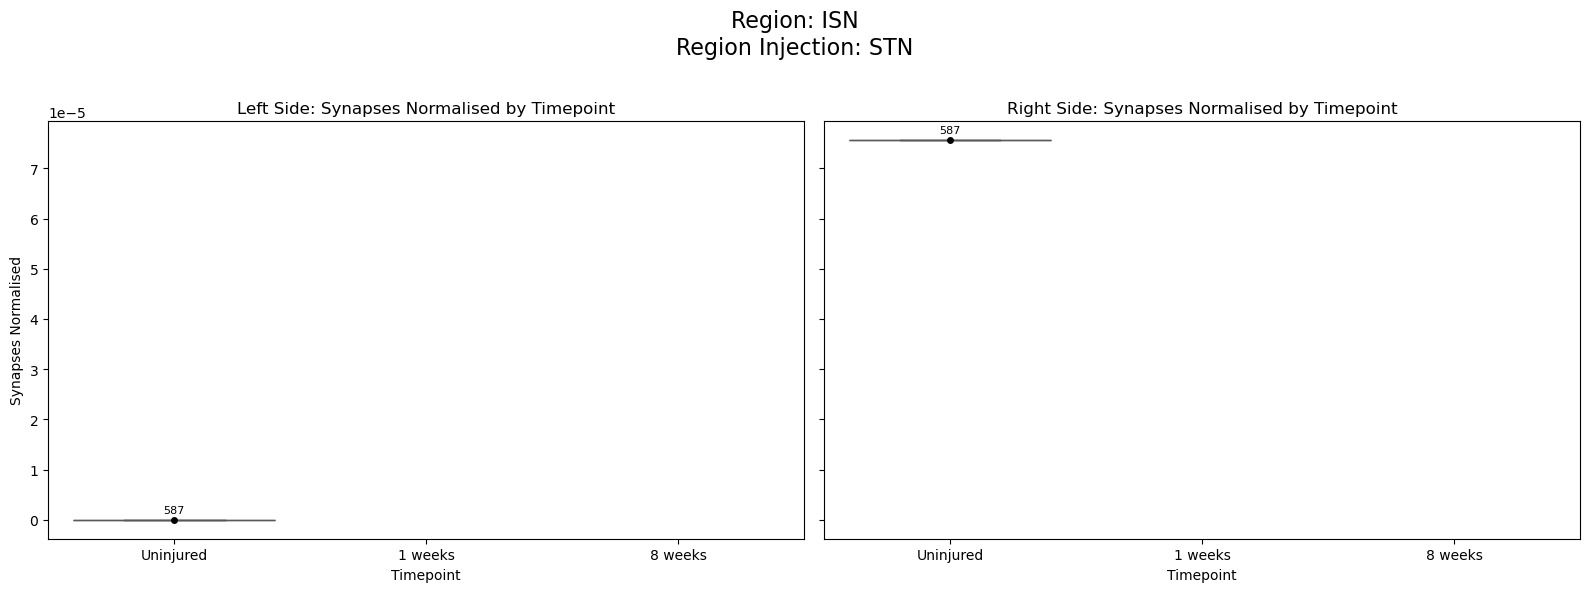

In [54]:
##############################################
### MANDATORY INPUTS #########################
##############################################

# Lsit all region of injection
regions_injection = df_all["Region Injection"].unique()

# !!!!!!!!!!!!!!!!!!!CHOSE WHICH REGION TO PLOT !!!!!!!!!!!!
#regions = df_all["Region"].unique() # PLOT ALL
    # OR
regions = ["ISN"]

# !!!!!!!!!!!!!!!!!!!CHOSE IF TO SAVE THE PLOTS !!!!!!!!!!!!
save_plot = True

# Define the desired order for the x-axis categories
timepoint_order = ["Uninjured", "1 weeks", "8 weeks"]

########################################################################

# Calculate normalized Syanpses counts
brain_IDs = df_all["Brain ID"].unique()
df_norm = df_all.copy()

# ATTENTION: you have to normalize, using the tot of each brain
# OBSERVATION: the total of each brain is the sum of all the leaves
df_norm["Normalised Synapses"] = 0
for ID in brain_IDs:
    tot_synapses = df_all[(df_all["Brain ID"] == ID) & (df_all["IsLeaf"] == True)]["Synapses"].sum()
    if tot_synapses == 0:
        print(f"\tATTENTION: brain {ID} has no synapses.")
    df_norm.loc[df_norm["Brain ID"] == ID, "Normalised Synapses"] = df_norm.loc[df_norm["Brain ID"] == ID, "Synapses"] / tot_synapses
#df_norm["Normalised Synapses"] = df_norm.groupby("Brain ID")["Synapses"].transform(lambda x: x / x.sum())

for region_injection in regions_injection:

    # Select sample of only specific region injection
    df_norm_region_injection = df_norm.copy()
    df_norm_region_injection = df_norm_region_injection[(df_norm_region_injection["Region Injection"] == region_injection)]

    for region in regions:

        # Create a figure with 1 row and 2 columns for subplots, sharing the x-axis
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
        fig.suptitle(f'Region: {region}\nRegion Injection: {region_injection}', fontsize=16)

        #### LEFT PLOT
        side = "Left"

        # Filter data for the left side
        df_roi_left = df_norm_region_injection[(df_norm_region_injection["Region"] == region) & (df_norm_region_injection["Side"] == side)]

        # Create the boxplot with jittered data points on the left subplot
        sns.boxplot(ax=axes[0], x="TimePoint", y="Normalised Synapses", data=df_roi_left, 
                    palette="Set2", order=timepoint_order)
        jitter_plot = sns.stripplot(ax=axes[0], x="TimePoint", y="Normalised Synapses", data=df_roi_left, 
                                    color="black", size=5, jitter=False, order=timepoint_order)

        # Annotate each point
        for i in range(df_roi_left.shape[0]):
            axes[0].annotate(df_roi_left["Brain ID"].iloc[i],  # Replace "Name" with the column containing your labels
                            (df_roi_left["TimePoint"].iloc[i], df_roi_left["Normalised Synapses"].iloc[i]),
                            textcoords="offset points",
                            xytext=(0,5),  # Adjust the offset as needed
                            ha='center',
                            fontsize=8)

        # Customize the left plot
        axes[0].set_title("Left Side: Synapses Normalised by Timepoint")
        axes[0].set_ylabel("Synapses Normalised")
        axes[0].set_xlabel("Timepoint")

        #### RIGHT PLOT
        side = "Right"

        # Filter data for the right side
        df_roi_right = df_norm_region_injection[(df_norm_region_injection["Region"] == region) & (df_norm_region_injection["Side"] == side)]

        # Create the boxplot with jittered data points on the right subplot
        sns.boxplot(ax=axes[1], x="TimePoint", y="Normalised Synapses", data=df_roi_right, 
                    palette="Set2", order=timepoint_order)
        jitter_plot = sns.stripplot(ax=axes[1], x="TimePoint", y="Normalised Synapses", data=df_roi_right, 
                                color="black", size=5, jitter=False, order=timepoint_order)

        # Annotate each point
        for i in range(df_roi_right.shape[0]):
            axes[1].annotate(df_roi_right["Brain ID"].iloc[i],  # Replace "Name" with the column containing your labels
                            (df_roi_right["TimePoint"].iloc[i], df_roi_right["Normalised Synapses"].iloc[i]),
                            textcoords="offset points",
                            xytext=(0,5),  # Adjust the offset as needed
                            ha='center',
                            fontsize=8)

        # Customize the right plot
        axes[1].set_title("Right Side: Synapses Normalised by Timepoint")
        axes[1].set_ylabel("Synapses Normalised")
        axes[1].set_xlabel("Timepoint")

        # Adjust layout to prevent overlap
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle

        # Show the combined figure
        plt.show()

        # Define the path to save the figure
        if save_plot:
            save_path = os.path.join(dir_project, "Results", "boxplots_single_region", region_injection, f"{region}.pdf")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            fig.savefig(save_path)

## Barplot LogFC

In [15]:
df_all_pivot = df_all.pivot(index="ROI", columns=["Brain ID", "Region Injection", "TimePoint"], values="Cell Density")
    #Attnetion: now the name of a col is a list
print(df_all_pivot)
#print(df_all_pivot.columns)

Brain ID               100       101       602       601       200       201  \
Region Injection        DR        DR        DR        DR        DR        DR   
TimePoint          8 weeks   8 weeks Uninjured Uninjured   1 weeks   1 weeks   
ROI                                                                            
Left: AAA         0.000236  0.000184  0.000236  0.001032  0.000184  0.000158   
Left: ACA         0.000285  0.000262  0.000285  0.000214  0.000262  0.000292   
Left: ACAd        0.000316  0.000263  0.000316  0.000227  0.000263  0.000283   
Left: ACAd1       0.000121  0.000071  0.000121  0.000035  0.000071  0.000142   
Left: ACAd2/3     0.000243  0.000202  0.000243  0.000183  0.000202  0.000230   
...                    ...       ...       ...       ...       ...       ...   
Right: vhc        0.000030  0.000000  0.000030  0.000013  0.000000  0.000063   
Right: von        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
Right: vtd        0.002945  0.000000  0.

In [20]:
logFC_bound = 1000

combinations = {
    "logFC_1weeks_uninjured": ["1 weeks", "Uninjured"],
    "logFC_8weeks_1week": ["8 weeks", "1 weeks"],
    "logFC_8weeks_uninjured": ["8 weeks", "Uninjured"]
}

for i, region in enumerate(region_injections):

    print(f"Processing Region {region}")

    # Select only mice of specific region
    ok_cols = [col for col in df_all_pivot.columns if region in col[1]]
    df_region = df_all_pivot[ok_cols]

    if df_region.empty:
        print(f"\tATTENTION: No Samples for region {region}")
        continue

    #print(df_region)

    for key, (treatment, baseline) in combinations.items(): 

        treatment_cols = [col for col in df_region.columns if treatment in col[2]] #Yake the cols (i.e mice) of tretment cpnditon
        baseline_cols = [col for col in df_region.columns if baseline in col[2]]

        df_treatment = df_region[treatment_cols]
        df_baseline = df_region[baseline_cols]

        #print(df_treatment)

        if df_treatment.empty or df_baseline.empty:
            print(f"\tATTENTION: In comparison {key}, one TimePoint is Missing.")
            continue

        # create a co that for each ROI (i,e row), calcutes the meanc
        df_temp = pd.DataFrame({'ROI' : df_treatment.index})
        df_temp['Mean Treatment'] = df_treatment.mean(axis=1).values
        df_temp['Mean Baseline'] = df_baseline.mean(axis=1).values

        #print(df_temp)

        # Calculate the logFC
            # Go thorugh each row(ie. ROI) of df_temp and caluclte logFC
        logFC = []
        for _, row in df_temp.iterrows():

            logFC_roi = 0
            mean_baseline = row["Mean Baseline"]
            mean_treatment = row["Mean Treatment"]

            if mean_baseline == 0 and mean_treatment == 0: # Not important case
                logFC_roi = 0
            elif mean_baseline == 0 and mean_treatment != 0:
                logFC_roi = logFC_bound
            elif mean_baseline != 0 and mean_treatment == 0:
                logFC_roi = -logFC_bound
            elif mean_baseline != 0 and mean_treatment != 0: # Normal case
                logFC_roi = np.log2(mean_treatment / mean_baseline)

            logFC.append(logFC_roi)

        # Add col    
        df_temp["LogFC"] = logFC

        # Sort values
        df_temp = df_temp.sort_values(by="LogFC", ascending=False)

        #print(df_temp)

        # Take the biggest and smallest in absolute values ROI with logFC
        # Also take the ones that have been bounded

        # Filter for extreme ROIs based on the logFC bound
        extreme_rois = df_temp[~((df_temp["LogFC"] < logFC_bound) & (df_temp["LogFC"] > -logFC_bound))]["ROI"].to_list()
            # NB .index is the names of the ROI column
    
        # Take only NORMAL ROIs (within the bounds)
        t = df_temp[(df_temp["LogFC"] < logFC_bound) & (df_temp["LogFC"] > -logFC_bound)]

        # Get top and bottom NORMAL ROIs
        top_rois = t.head(n_roi_displayed)["ROI"].to_list() # Take the biggest
        bottom_rois = t.tail(n_roi_displayed)["ROI"].to_list() # Take the smallest

        # Filter the original DataFrame to include top, bottom, and extreme ROIs
        t = df_temp[
            df_temp["ROI"].isin(top_rois) | 
            df_temp["ROI"].isin(bottom_rois) | 
            df_temp["ROI"].isin(extreme_rois)
        ]

        #print(t)

        t = t.sort_values(by = "LogFC", ascending=False)

        # Create the bar plot
        fig, ax = plt.subplots(figsize=(20, 10 ))
        bars = plt.bar(t["ROI"], t["LogFC"])

        ax.set_xlabel('ROI')
        ax.set_ylabel(key)
        ax.set_title('Most extreme changed in LogFC')
        ax.set_xticks(range(len(t.index)))
        ax.set_xticklabels(t["ROI"], rotation=45, ha='right')
        ax.set_ylim(bottom = -10, top = 10)
        #plt.show()

        # Create reuslt folder
        injection_folder = search_injection_folder(dir_project, region) # Search the dolfer of the injection
        result_folder = os.path.join(injection_folder, "Results") 
        os.makedirs(result_folder, exist_ok=True)

        #Save fig
        save_path = os.path.join(result_folder, f"logFC_1weeks_uninjured_{region}_{n_roi_displayed}.pdf")
        #fig.savefig(save_path)
        print(f"\tSaved {key} for region {region}")

plt.close("all")

Processing Region DR
	Saved logFC_1weeks_uninjured for region DR
	Saved logFC_8weeks_1week for region DR
	Saved logFC_8weeks_uninjured for region DR
Processing Region GPi
	ATTENTION: In comparison logFC_1weeks_uninjured, one TimePoint is Missing.
	ATTENTION: In comparison logFC_8weeks_1week, one TimePoint is Missing.
	ATTENTION: In comparison logFC_8weeks_uninjured, one TimePoint is Missing.
Processing Region STN
	ATTNETION: No Samples for region STN
Processing Region PARN
	ATTNETION: No Samples for region PARN
Processing Region IF
	ATTNETION: No Samples for region IF
Processing Region GPe
	Saved logFC_1weeks_uninjured for region GPe
	Saved logFC_8weeks_1week for region GPe
	Saved logFC_8weeks_uninjured for region GPe
Processing Region CU
	ATTNETION: No Samples for region CU
Processing Region BST
	ATTNETION: No Samples for region BST
